In [ ]:
log_path = 'fixed_value/2025-10-21'
import numpy as np
import re
import os
from omegaconf import OmegaConf
from flp2p.utils import compute_weight_matrix
import networkx as nx
import pickle
from flp2p.matcha_mixing_matrix import getAlpha, getProbability, getSubGraphs, graphToLaplacian

def get_metrics(data):
    overall_distance_p = re.compile(r'Overall consensus distance : ([\d\.]+)')
    inter_cluster_distance_p = re.compile(r'Inter-cluster distance : ([\d\.]+)')
    cluster_1_distance_p =  re.compile(r'Inter-cluster distance : ([\d\.]+)')
    cluster_2_distance_p =  re.compile(r'Cluster 2 consensus distance : ([\d\.]+)')
    
    overall_distance, inter_cluster_distance, cluster_1_distance, cluster_2_distance = [], [], [], []
    for match in overall_distance_p.finditer(data):
        overall_distance.append(float(match.group(1)))
        
    for match in inter_cluster_distance_p.finditer(data):
        inter_cluster_distance.append(float(match.group(1)))
    
    for match in cluster_1_distance_p.finditer(data):
        cluster_1_distance.append(float(match.group(1)))
           
    for match in cluster_2_distance_p.finditer(data):
        cluster_2_distance.append(float(match.group(1)))

    return {"overall_distance": overall_distance,
            "inter_cluster_distance": inter_cluster_distance,
            "cluster_1_distance": cluster_1_distance,
            "cluster_2_distance": cluster_2_distance}

res = {}
for log_dir in os.listdir(log_path):
    log_file  = f'{log_path}/{log_dir}'
    if os.path.isfile(log_file):
        continue
    if log_dir == "15-38-50":
        continue
    with open(f'{log_file}/fixed_value_training.log', 'r') as f:
        data = f.read()
    config_file = OmegaConf.load(f'{log_file}/.hydra/config.yaml') 
    with open(f'{log_file}/graph.pickle', 'rb') as f:
        graph = pickle.load(f)
            
    W = compute_weight_matrix(graph, config_file.mixing_matrix)
    eigenval = sorted(np.linalg.eig(W).eigenvalues, reverse=True)
    algebric_value = 1 - max(abs(eigenval[1]), abs(eigenval[-1]))
    res_dict = get_metrics(data)
    res[f'{log_dir.split('/')[-1]}_{config_file.mixing_matrix}'] = res_dict
    res[f'{log_dir.split('/')[-1]}_{config_file.mixing_matrix}']['spectral_gap'] = algebric_value


In [21]:
[res[key]['spectral_gap'] for key in res]

[np.float64(0.0011627600059274101),
 np.float64(0.0011918290060756176),
 np.float64(1.0)]

In [22]:
for log_dir in os.listdir(log_path):
    log_file  = f'{log_path}/{log_dir}'
    if os.path.isfile(log_file):
        continue
    if log_dir == "15-38-50":
        continue
    with open(f'{log_file}/fixed_value_training.log', 'r') as f:
        data = f.read()
    config_file = OmegaConf.load(f'{log_file}/.hydra/config.yaml') 
    with open(f'{log_file}/graph.pickle', 'rb') as f:
        graph = pickle.load(f)  
    if config_file.mixing_matrix == 'matcha':
        algebric_values = []
        W = list()
        n_nodes = len(graph.nodes)
        subgraphs = getSubGraphs(graph, n_nodes)
        laplacians = graphToLaplacian(subgraphs, n_nodes)
        probas = getProbability(laplacians, 2/5)
        alpha = getAlpha(laplacians, probas, n_nodes)
        for _ in range(config_file.train.rounds):
            L_k = np.sum([laplacians[i] for i in range(len(subgraphs)) if np.random.random() < probas[i]], axis=0)
            eigenval = sorted(np.linalg.eig(np.eye(n_nodes) - alpha * L_k).eigenvalues, reverse=True)
            algebric_values.append(1 -max(abs(eigenval[1]), abs(eigenval[-1])))

KeyboardInterrupt: 

In [23]:
algebric_values

[]

In [140]:
print(list(res.keys()))
print(list(res[list(res.keys())[0]].keys()))

['13-48-38_metropolis_hasting', '13-58-49_maximum_degree', '14-42-14_matcha']
['overall_distance', 'inter_cluster_distance', 'cluster_1_distance', 'cluster_2_distance', 'spectral_gap']


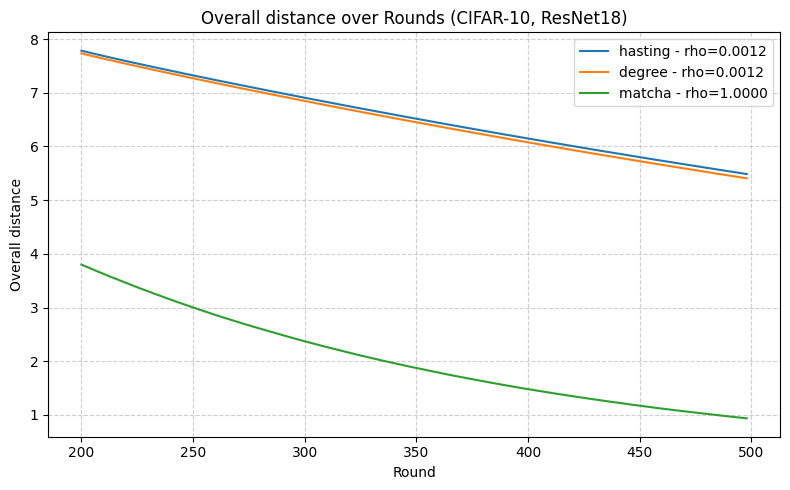

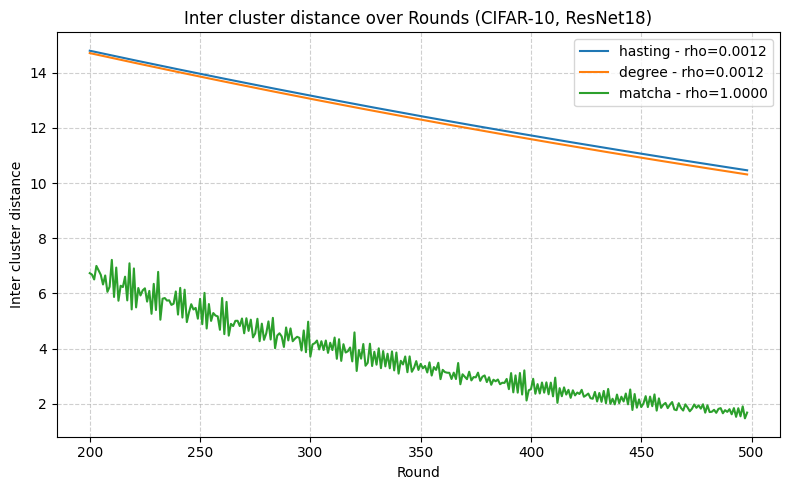

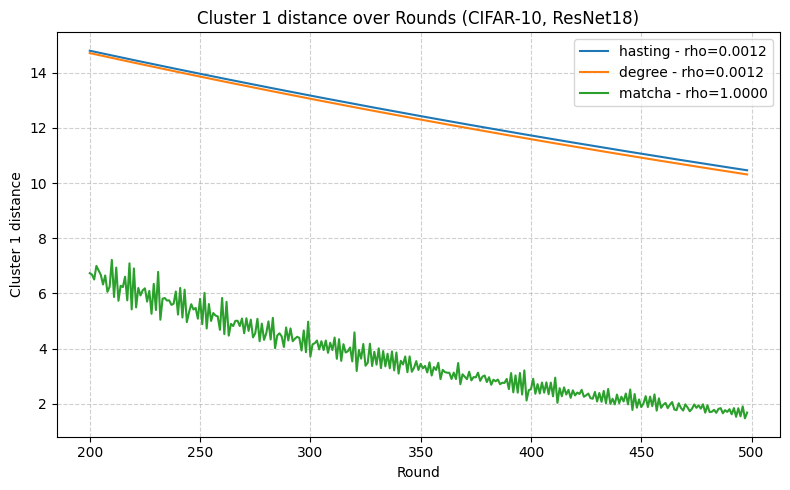

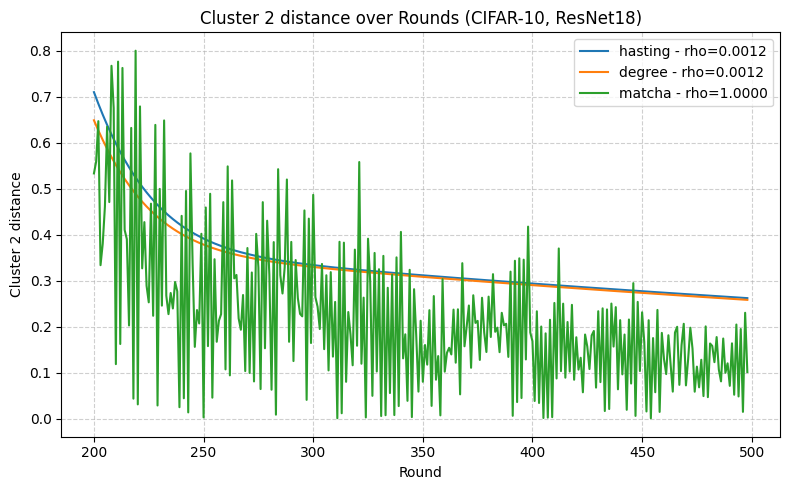

TypeError: object of type 'numpy.float64' has no len()

<Figure size 800x500 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
keys = list(res.keys())
index_elems = list(res[keys[0]].keys())
epochs = min(499, min(len(res[k][index_elems[0]]) for k in keys))  
start = 200
for index_elem in index_elems:
    plt.figure(figsize=(8, 5))
    
    for key in keys:
        y = res[key].get(index_elem, None)
        if y is None or len(y) == 0:
            continue
        y = y[start:epochs]
        rounds = np.arange(start, start + len(y))
        label = f"{key.split('_')[-1]} - rho={res[key].get('spectral_gap', 'N/A'):.4f}" \
                if 'spectral_gap' in res[key] else key
        plt.plot(rounds, y, label=label)
    
    plt.xlabel("Round")
    plt.ylabel(index_elem.replace('_', ' ').capitalize())
    plt.title(f"{index_elem.replace('_', ' ').capitalize()} over Rounds (CIFAR-10, ResNet18)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()